In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Google drive bağlantısını yapalım.

Mounted at /content/drive


In [2]:
import pandas as pd
dosya_yolu = '/content/drive/MyDrive/cti-academy/wustl-ehms-2020.csv'
df = pd.read_csv(dosya_yolu)
df.head()
# Drive'dan veri setini okuyalım.

,Dir,Flgs,SrcAddr,DstAddr,Sport,Dport,SrcBytes,DstBytes,SrcLoad,DstLoad,...,Temp,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Attack Category,Label
0,->,e,10.0.1.172,10.0.1.150,58059,1111,496,186,276914.0,92305.0,...,28.9,0,0,0,0,0,0,0.0,normal,0
1,->,e,10.0.1.172,10.0.1.150,58062,1111,496,186,230984.0,76995.0,...,28.9,0,0,0,0,78,17,0.4,normal,0
2,->,e,10.0.1.172,10.0.1.150,58065,1111,496,186,218470.0,72823.0,...,28.9,89,104,0,0,78,17,0.4,normal,0
3,->,e,10.0.1.172,10.0.1.150,58067,1111,496,186,203376.0,67792.0,...,28.9,89,104,0,0,79,17,0.4,normal,0
4,->,e,10.0.1.172,10.0.1.150,58069,1111,496,186,235723.0,78574.0,...,28.9,89,101,0,0,79,17,0.4,normal,0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
# kütüphaneleri yükleyelim

In [4]:
df_clean = df.drop(columns=["SrcAddr", "DstAddr", "SrcMac", "DstMac", "Attack Category"])
# Kimlik belirten sütunları atalım.

le = LabelEncoder()
for col in ["Dir", "Flgs", "Sport"]:
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
# metinsel değerleri sayısal değerlere dönüştürülelim.

X = df_clean.drop("Label", axis=1)
y = df_clean["Label"].values
# x giriş, y hedef, 0 normal, 1 saldırı

In [5]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
#Verinin %80’ini eğitim, %20’sini test için ayıralım
# stratify=y ile saldırı-normal oranını koruyalım

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
# sadece eğitimden öğrenmeli ve testi buna göre dönüştürmeli

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
#cnn girişi için örnek, özellik, kanal boyutlandıralım.

In [6]:
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}
# ağ trafiğinde normal veri fazla, saldırı verisi az.

In [7]:
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True)
# en yüksek doğrulama başarımına sahip epoch değerini kaydedelim.


history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5935 - loss: 0.6640 - val_accuracy: 0.8464 - val_loss: 0.5235
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8044 - loss: 0.5489 - val_accuracy: 0.8755 - val_loss: 0.5412
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8547 - loss: 0.5528 - val_accuracy: 0.9360 - val_loss: 0.3695
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8864 - loss: 0.5179 - val_accuracy: 0.9000 - val_loss: 0.5512
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8917 - loss: 0.5199 - val_accuracy: 0.9357 - val_loss: 0.4204
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8793 - loss: 0.5131 - val_accuracy: 0.9360 - val_loss: 0.4245
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8825 - loss: 0.5003 - val_accuracy: 0.8047 - val_loss: 0.5381
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8286 - loss: 0.5034 - val_accu

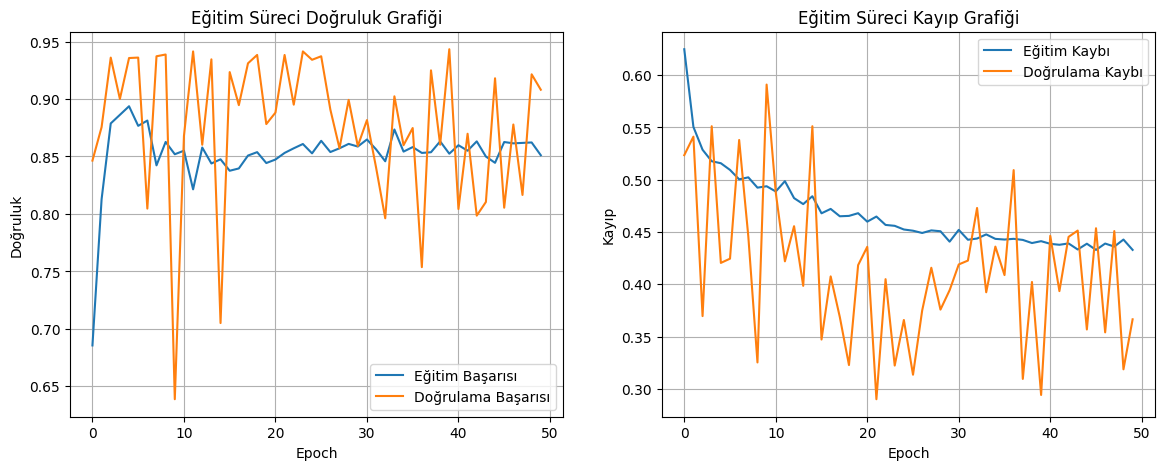

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


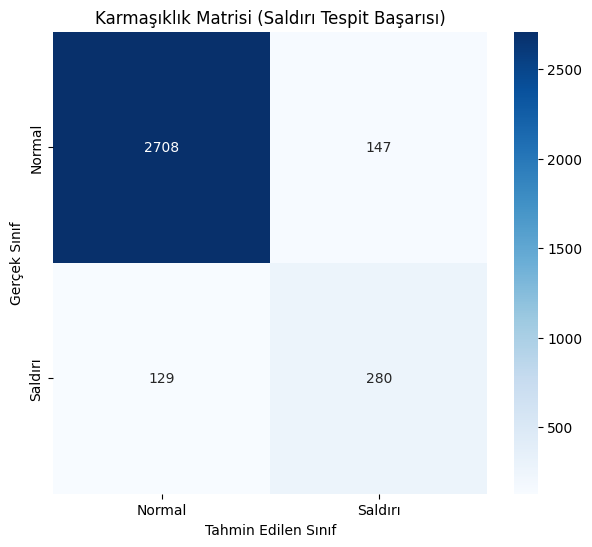


Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2855
           1       0.66      0.68      0.67       409

    accuracy                           0.92      3264
   macro avg       0.81      0.82      0.81      3264
weighted avg       0.92      0.92      0.92      3264



In [8]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Başarısı')
plt.plot(history.history['val_accuracy'], label='Doğrulama Başarısı')
plt.title('Eğitim Süreci Doğruluk Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim Süreci Kayıp Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)
plt.show()
# doğruluk-kayıp grafikleri

y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Saldırı'], yticklabels=['Normal', 'Saldırı'])
plt.title('Karmaşıklık Matrisi (Saldırı Tespit Başarısı)')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.show()
# confusion matrix

print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))
# metrik rapor

In [10]:
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_acc = np.max(history.history['val_accuracy'])

print(f"En iyi doğrulama başarısı {best_val_acc:.4f} ile {best_epoch}. epoch'ta elde edilmiştir.")


En iyi doğrulama başarısı 0.9433 ile 40. epoch'ta elde edilmiştir.


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


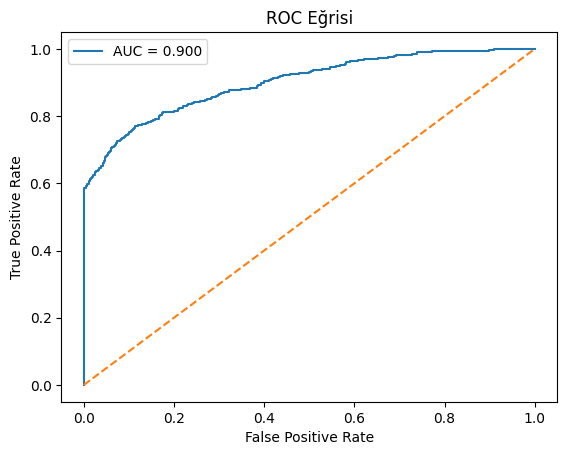

In [11]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi")
plt.legend()
plt.show()
# roc eğrisi